In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
id='1cU16m88Z5TG1O-3tcg7xr71_YD864Y9N'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

In [5]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')  
data= pd.read_csv('train.csv')
data1=data.copy()

In [6]:
data=data1.copy()
data['Date']=pd.to_datetime(data['Date'].astype(str),format='%Y%m%d',errors='coerce')
data=data.set_index('Date')
imputer=SimpleImputer()
imp_data=pd.DataFrame(imputer.fit_transform(data),index=data.index)
imp_data.columns=data.columns
scaler=MinMaxScaler()
sca_data=pd.DataFrame(scaler.fit_transform(imp_data),index=data.index)
sca_data.columns=data.columns

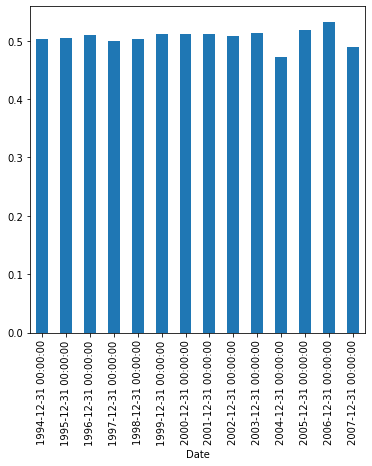

In [7]:
sca_data['BRIS'].resample('A').mean().plot(kind='bar',figsize=(6,6))

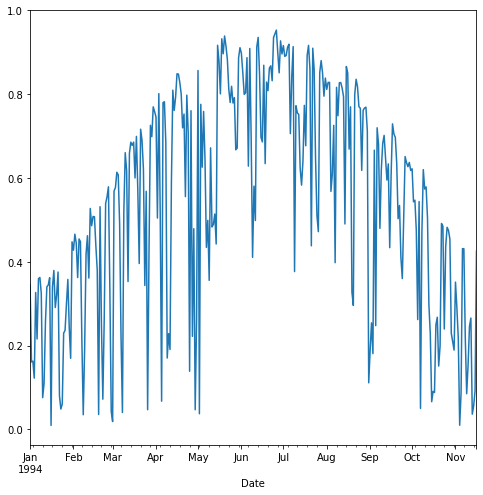

In [8]:
sca_data['BRIS'].head(320).plot(figsize=(8,8))

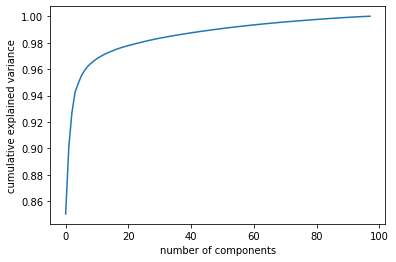

In [9]:
from sklearn.decomposition import PCA
pca=PCA()
prin_data=pd.DataFrame(pca.fit_transform(sca_data))
#prin_x_train,prin_x_test,prin_y_train,prin_y_test=train_test_split(prin_data,y,test_size=0.2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [10]:
pca=PCA(n_components=0.98)
prin_data=pd.DataFrame(pca.fit_transform(sca_data))
print(pca.n_components_)
no= pca.n_components_ 
imp= [np.abs(pca.components_[i]).argmax() for i in range(no)]
names= sca_data.columns
imp_names= [names[imp[i]] for i in range(no)]
imp_names[0]

25


'BRIS'

In [11]:
data=pd.DataFrame(data1['BRIS'])
print(data.shape)
data.isnull().sum()

(5113, 1)


BRIS    18
dtype: int64

In [12]:
data=data.dropna()
print(data.shape)
data.isnull().sum()

(5095, 1)


BRIS    0
dtype: int64

In [13]:
data=data['BRIS'].values.astype('float32')
max=np.max(data)
min=np.min(data)
df=[]
for i in range(len(data)):
  a=(data[i]-min)/(max-min)
  if(a!=0):
    df.append(a)
df=np.array(df)
len(df)

5094

In [14]:
def create_dataset(data,n_features):
  x,y=[],[]
  for i in range(data.shape[0]):
    end=i+n_features
    if end>data.shape[0]-1:
      break;
    xse,yse=data[i:end],data[end]
    x.append(xse)
    y.append(yse)
  return np.array(x),np.array(y)

In [43]:
n_features=7
x,y=create_dataset(df,n_features)
n=1
x=x.reshape((x.shape[0],x.shape[1],n))
print(x.shape,y.shape)

(5087, 7, 1) (5087,)


In [47]:
train_size = int(len(data) * 0.90)
test_size = len(data) - train_size
x_train,x_test = x[0:train_size], x[train_size:len(data)]
y_train,y_test = y[0:train_size], y[train_size:len(data)]
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(4601, 7, 1) (4601,)
(486, 7, 1) (486,)


In [17]:
import tensorflow as tf
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [48]:
from keras.optimizers import SGD
model= Sequential()
model.add(Dense(100,activation=tf.nn.relu,input_shape=(n_features,n)))
model.add(LSTM(50,activation=tf.nn.relu,return_sequences=True))
model.add(LSTM(50,activation=tf.nn.relu))
Dropout(0.2)
model.add(Dense(1))
model.compile(optimizer='adam',loss=tf.keras.losses.mean_absolute_error )

In [49]:
history=model.fit(x_train,y_train,epochs=30,batch_size=64,verbose=0,validation_data=(x_test,y_test))

In [66]:
results=model.evaluate(x_test,y_test,batch_size=100)

5/5 [==============================] - 0s 5ms/step - loss: 0.1310


In [21]:
print(history)
results

0.15078894793987274

In [67]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 7, 100)            200       
_________________________________________________________________
lstm_8 (LSTM)                (None, 7, 50)             30200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 50,651
Trainable params: 50,651
Non-trainable params: 0
_________________________________________________________________


In [50]:
train_pre=model.predict(x_train)
test_pre=model.predict(x_test)

In [51]:
print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_pre))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_pre)))
print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_pre))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_pre)))

Train Mean Absolute Error: 0.13373461
Train Root Mean Squared Error: 0.18291613
Test Mean Absolute Error: 0.13097972
Test Root Mean Squared Error: 0.17756453


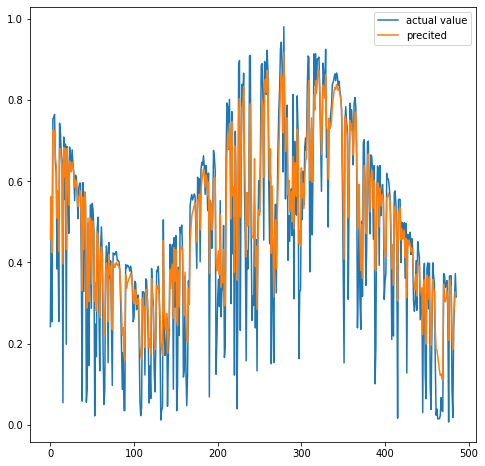

In [68]:
fig, ax = plt.subplots(figsize=(8,8))
noo=int(len(y_test)/1)#to divide the graph into parts for displaying
ax.plot(y_test[0:noo], label='actual value')
ax.plot(test_pre[1:noo], label='precited')
leg = ax.legend()

No handles with labels found to put in legend.


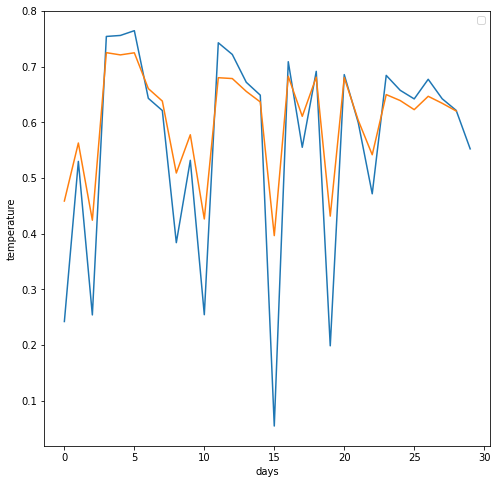

In [53]:
plt.figure(figsize=(8,8))
plt.xlabel("days")
plt.ylabel("temperature")
plt.legend()
plt.plot(y_test[0:30],label="actual")
plt.plot(test_pre[1:30],label="predicted")

In [ ]:
#using Arima model

In [30]:
data=sca_data['BRIS'].values
train_size = int(len(data) * 0.80)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:len(data)]

In [65]:
! pip install pmdarima
from pmdarima import auto_arima
model= auto_arima(data, start_p=1, start_q=1,max_p=5, max_q=5, m=12,start_P=0, seasonal=True,d=None, D=1, trace=True,error_action='ignore', suppress_warnings=True, stepwise=True)           

In [59]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
mod= SARIMAX(train,order=(2,0,3),seasonal_order=(2,1,2,12))
result=mod.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [60]:
predictions = result.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False, typ='levels')

In [61]:
error = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE Error: {error:11.10}')

RMSE Error: 0.2507219733


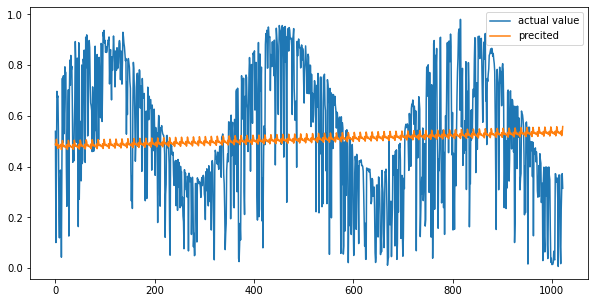

In [62]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(test, label='actual value')
ax.plot(predictions, label='precited')
leg = ax.legend();

In [69]:
# invert predictions from RNN
scaler=MinMaxScaler()
rand=scaler.fit(train_pre)
train_predicts = scaler.inverse_transform(train_pre)
y_trains= scaler.inverse_transform([y_train])
test_predicts = scaler.inverse_transform(test_pre)
y_tests = scaler.inverse_transform([y_test])
print('Train Mean Absolute Error:', mean_absolute_error(y_trains[0], train_predicts[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_trains[0], train_predicts[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(y_tests[0], test_predicts[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_tests[0], test_predicts[:,0])))

Train Mean Absolute Error: 0.11278619923706242
Train Root Mean Squared Error: 0.15426383220713588
Test Mean Absolute Error: 0.11046282947444674
Test Root Mean Squared Error: 0.14975051938736883


In [ ]:
#comparing both models we can see that rnn performed better than arima model